<a href="https://colab.research.google.com/github/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_2_Hero_Pro_%2B_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX: from Hero to Hero Pro+

aka: on the way to building fully fledged Neural Networks! ❤️

Note1: this notebook heavily relies on https://jax.readthedocs.io/en/latest/ + some additional code/modifications, comments/notes, etc.

Note2: YouTube video incoming (check out [notebook](https://github.com/gordicaleksa/get-started-with-JAX/blob/main/Tutorial_1_JAX_basics_Colab.ipynb) and [YouTube video](https://www.youtube.com/watch?v=SstuvS-tVc0) for tutorial #1).

Note3: I'm still developing this notebook for tutorial #2.

In [2]:
import jax
import jax.numpy as jnp
import numpy as np

from jax import grad, jit, vmap, pmap

from jax import random
import matplotlib.pyplot as plt
from copy import deepcopy
from typing import Tuple

## The Problem of State

JAX ❤️ Pure Functions => JAX "!❤️" State.

In [ ]:
# 1) We've seen in the last notebook/video that impure functions are problematic.

g = 0.  # state

# We're accessing some external state in this function which causes problems
def impure_uses_globals(x):
    return x + g

# JAX captures the value of the global/state during the first run
print ("First call: ", jit(impure_uses_globals)(4.))

# Let's update the global/state!
g = 10.

# Subsequent runs may silently use the cached value of the globals/state
print ("Second call: ", jit(impure_uses_globals)(5.))

In [ ]:
# 2) We've also seen this pattern how JAX's PRNG 
# (which is not stateful in contrast to NumPy's PRNG) is handling state.

seed = 0
state = jax.random.PRNGKey(seed)

# We input the state, we somehow manipulate it and we return it back.
# The state is not saved internally.
state1, state2 = jax.random.split(state)  # recall: key/subkey was the terminology we used

In [ ]:
# Let's now explictly address and understand the problem of state!
# Why? 
# Well, NNs love statefulness: model params, optimizer params, BatchNorm, etc.
# and we've seen that JAX seems to have a problem with it.

class Counter:
    """A simple counter."""

    def __init__(self):
        self.n = 0

    def count(self) -> int:
        """Increments the counter and returns the new value."""
        self.n += 1
        return self.n

    def reset(self):
        """Resets the counter to zero."""
        self.n = 0


counter = Counter()

for _ in range(3):  # works like a charm
    print(counter.count())

In [ ]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):  # oops, it's not working as it's supposed to be
    print(fast_count())

In [ ]:
from jax import make_jaxpr  # let's use jaxpr to understand why this is happening

counter.reset()
print(make_jaxpr(counter.count)())

In [ ]:
# Solution:

CounterState = int  # our counter state is implemented as a simple integer

class CounterV2:

    def count(self, n: CounterState) -> Tuple[int, CounterState]:
        # You could just return n+1, but here we separate its role as 
        # the output and as the counter state for didactic purposes.
        # (as the output may be some arbitrary function of state in general case)
        return n+1, n+1

    def reset(self) -> CounterState:
        return 0

counter = CounterV2()
state = counter.reset()  # notice how reset() now returns state (external vs internal imp)

for _ in range(3):  # works like a charm pre-jit, let's see whether the jit version works
    value, state = counter.count(state)  # looks familiar?
    print(value)

In [ ]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):  # nice, working as expected!
    value, state = fast_count(state)
    print(value)

In summary we used the following pattern:

```python
class StatefulClass

    state: State

    def stateful_method(*args, **kwargs) -> Output:
```

and turned it into a class of the form

```python
class StatelessClass

    def stateless_method(state: State, *args, **kwargs) -> (Output, State):
```

## Enter PyTree



Before we start - why do we need it in the first place?


In [ ]:
f = lambda x, y, z, w: x**2 + y**2 + z**2 + w**2  # + 175B params more (minus 4 of course)

# JAX: .backward() is not that great
# also JAX:
x, y, z, w = [1.]*4
dfdx, dfdy, dfdz, dfdw = grad(f, argnums=(0, 1, 2, 3))(x, y, z, w)
print(dfdx, dfdy, dfdz, dfdw)

# Great now we just need to update our params!
# lr = 0.001
# x -= lr*dfdx
# y -= lr*dfdy
# ... (175B lines later)
# w -= lr*dfdw

# no, no we have a better way.

In [7]:
# We'll want to, more naturally, wrap our params in some more complex
# data structures like dictionaries, etc. 
# JAX knows how to deal with these!

# A contrived example for pedagogical purposes
# (if your mind needs to attach some semantics to parse this - treat it as model params)
example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have:
for pytree in example_trees:
    leaves = jax.tree_leaves(pytree)
    print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

[1, 'a', <object object at 0x7f5161d3a450>]   has 3 leaves: [1, 'a', <object object at 0x7f5161d3a450>]
(1, (2, 3), ())                               has 3 leaves: [1, 2, 3]
[1, {'k1': 2, 'k2': (3, 4)}, 5]               has 5 leaves: [1, 2, 3, 4, 5]
{'a': 2, 'b': (2, 3)}                         has 3 leaves: [2, 2, 3]
DeviceArray([1, 2, 3], dtype=int32)           has 1 leaves: [DeviceArray([1, 2, 3], dtype=int32)]


In [15]:
# How do we manipulate PyTrees?

list_of_lists = [
    {'a': 3},
    [1, 2, 3],
    [1, 2],
    [1, 2, 3, 4]
]

# In single arg functions use tree_map
# It iterates through leaves and applies the lambda function
print(jax.tree_map(lambda x: x*2, list_of_lists)) 

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


In [16]:
another_list_of_lists = list_of_lists
print(jax.tree_multimap(lambda x, y: x+y, list_of_lists, another_list_of_lists))

[{'a': 6}, [2, 4, 6], [2, 4], [2, 4, 6, 8]]


In [ ]:
# PyTrees need to have the same structure if we are to apply tree_multimap!
another_list_of_lists = deepcopy(list_of_lists)
another_list_of_lists.append([23])
print(jax.tree_multimap(lambda x, y: x+y, list_of_lists, another_list_of_lists))

### Less contrived example: toy MLP training

In [17]:
def init_mlp_params(layer_widths):
  params = []

  for n_in, n_out in zip(layer_widths[:-1], layer_widths[1:]):
    params.append(
        dict(weights=np.random.normal(size=(n_in, n_out)) * np.sqrt(2/n_in),
                biases=np.ones(shape=(n_out,))
        )
    )

  return params

# Single input single output, 3 layers
params = init_mlp_params([1, 128, 128, 1])

# Another example of how we might use tree_map
jax.tree_map(lambda x: x.shape, params)

[{'biases': (128,), 'weights': (1, 128)},
 {'biases': (128,), 'weights': (128, 128)},
 {'biases': (1,), 'weights': (128, 1)}]

In [44]:
def forward(params, x):
    *hidden, last = params

    for layer in hidden:
        x = jax.nn.relu(jnp.dot(x, layer['weights']) + layer['biases'])

    return jnp.dot(x, last['weights']) + last['biases']

def loss_fn(params, x, y):
    return jnp.mean((forward(params, x) - y) ** 2)  # MSE loss

lr = 0.0001

@jit  # notice how we do jit only at the highest level - XLA will have plenty of space to optimize
def update(params, x, y):

    # Note that grads is a pytree with the same structure as params.
    # grad is one of the many JAX functions that has built-in support for pytrees.
    grads = jax.grad(loss_fn)(params, x, y)

    # This is handy, because we can apply the SGD update using tree utils:
    return jax.tree_multimap(
        lambda p, g: p - lr * g, params, grads  # for every leaf i.e. for every param of MLP
    )

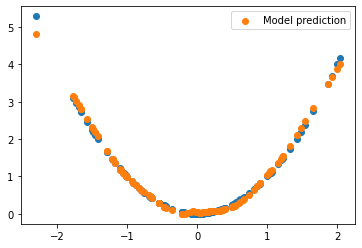

In [46]:
xs = np.random.normal(size=(128, 1))
ys = xs ** 2  # let's learn how to regress a parabola

for _ in range(1000):
    params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.scatter(xs, forward(params, xs), label='Model prediction')
plt.legend();

### Custom PyTrees

In [2]:
class MyContainer:
    """A named container."""
    def __init__(self, name: str, a: int, b: int, c: int):
        self.name = name
        self.a = a
        self.b = b
        self.c = c

In [4]:
example_pytree = [MyContainer('Alice', 1, 2, 3), MyContainer('Bob', 4, 5, 6)]  # 8 leaves? noup.

leaves = jax.tree_leaves(example_pytree)
print(f"{repr(example_pytree):<45}\n has {len(leaves)} leaves:\n {leaves}")

[<__main__.MyContainer object at 0x7fd17797ea90>, <__main__.MyContainer object at 0x7fd178fe6110>]
 has 2 leaves:
 [<__main__.MyContainer object at 0x7fd17797ea90>, <__main__.MyContainer object at 0x7fd178fe6110>]


In [ ]:
print(jax.tree_map(lambda x: x + 1, example_pytree))  # this will not work :/ it'd be nice if it did

In [5]:
# Let's get it to work! We'll need to define 2 functions (flatten/unflatten)

def flatten_MyContainer(container):
    """Returns an iterable over container contents, and aux data."""
    flat_contents = [container.a, container.b, container.c]

    # we don't want the name to appear as a child, so it is auxiliary data.
    # auxiliary data is usually a description of the structure of a node,
    # e.g., the keys of a dict -- anything that isn't a node's children.
    aux_data = container.name

    return flat_contents, aux_data

def unflatten_MyContainer(aux_data, flat_contents):
    """Converts aux data and the flat contents into a MyContainer."""
    return MyContainer(aux_data, *flat_contents)

# Register a custom PyTree node
jax.tree_util.register_pytree_node(MyContainer, flatten_MyContainer, unflatten_MyContainer)

# Let's try again!
leaves = jax.tree_leaves(example_pytree)
print(f"{repr(example_pytree):<45}\n has {len(leaves)} leaves:\n {leaves}")

[<__main__.MyContainer object at 0x7fd17797ea90>, <__main__.MyContainer object at 0x7fd178fe6110>]
 has 6 leaves:
 [1, 2, 3, 4, 5, 6]


In [7]:
result = jax.tree_map(lambda x: x + 1, example_pytree)
print(jax.tree_leaves(result))  # it works now as expected!

[2, 3, 4, 5, 6, 7]


In [14]:
# gotcha: mistaking nodes for leaves

zeros_tree = [jnp.zeros((2, 3)), jnp.zeros((3, 4))]

# Try to make another tree with ones instead of zeros
shapes = jax.tree_map(lambda x: x.shape, zeros_tree)

ones_tree = jax.tree_map(jnp.ones, shapes)
print(ones_tree)

# Task: debug this

[(DeviceArray([1., 1.], dtype=float32), DeviceArray([1., 1., 1.], dtype=float32)), (DeviceArray([1., 1., 1.], dtype=float32), DeviceArray([1., 1., 1., 1.], dtype=float32))]


## Parallelism in JAX

In [ ]:
import jax.tools.colab_tpu
jax.tools.colab_tpu.setup_tpu()

jax.devices()

In [77]:
# pmap works very similarly to vmap

x = np.arange(5)
w = np.array([2., 3., 4.])

def convolve(w, x):
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    return jnp.array(output)

result = convolve(w, x)
print(repr(result))

DeviceArray([11., 20., 29.], dtype=float32)


In [78]:
n_devices = jax.local_device_count() 
print(n_devices)

xs = np.arange(5 * n_devices).reshape(-1, 5)
ws = np.stack([w] * n_devices)

8


In [ ]:
vmap_result = jax.vmap(convolve)(xs, ws)
print(repr(vmap_result))

In [ ]:
pmap_result = jax.pmap(convolve)(xs, ws)
print(repr(pmap_result))  # ShardedDeviceArray!

In [ ]:
# no cross-device communication costs
double_pmap_result = jax.pmap(convolve)(xs, jax.pmap(convolve)(xs, ws))
print(repr(double_pmap_result))

In [ ]:
pmap_smarter_result = jax.pmap(convolve, in_axes=(None, 0))(w, xs)
print(repr(pmap_smarter_result))  # same results but we don't have to manually broadcast w

### Communication between devices

In [ ]:
def normalized_convolution(w, x):
    output = []

    for i in range(1, len(x)-1):
        output.append(jnp.dot(x[i-1:i+2], w))

    output = jnp.array(output)

    return output / jax.lax.psum(output, axis_name='p')

res_pmap = jax.pmap(normalized_convolution, axis_name='p', in_axes=(None, 1))(w, xs.T)
res_vmap = jax.vmap(normalized_convolution, axis_name='p')(ws, xs)
print(res_pmap)
print(sum(res_pmap[:, 0]))
print(res_vmap)

#### More involved example

In [ ]:
# Useful to know:
def sum_squared_error(x, y):
    return sum((x-y)**2)

x = jnp.arange(4, dtype=jnp.float32)
y = x + 0.1

# An efficient way to return both grads and loss value
jax.value_and_grad(sum_squared_error)(x, y)

In [ ]:
def sum_squared_error_with_aux(x, y):
    return sum((x-y)**2), x-y

jax.grad(sum_squared_error_with_aux)(x, y)  # has_aux=True

In [68]:
from typing import NamedTuple, Tuple
import functools

class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray

lr = 0.005


def init(rng):
    """Returns the initial model params."""
    weights_key, bias_key = jax.random.split(rng)
    weight = jax.random.normal(weights_key, ())
    bias = jax.random.normal(bias_key, ())
    return Params(weight, bias)


def model(params, xs):
    return params.weight * xs + params.bias


def loss_fn(params, xs, ys):
    """Computes the least squares error of the model's predictions on x against y."""
    pred = model(params, xs)
    return jnp.mean((pred - ys) ** 2)


@functools.partial(jax.pmap, axis_name='num_devices')
def update(params, xs, ys):
    """Performs one SGD update step on params using the given data."""

    # Compute the gradients on the given minibatch (individually on each device).
    loss, grads = jax.value_and_grad(loss_fn)(params, xs, ys)

    # Combine the gradient across all devices (by taking their mean).
    grads = jax.lax.pmean(grads, axis_name='num_devices')

    # Also combine the loss. Unnecessary for the update, but useful for logging.
    loss = jax.lax.pmean(loss, axis_name='num_devices')

    # If we were using Adam or another stateful optimizer,
    # we would also do something like
    # ```
    # updates, new_optimizer_state = optimizer(grad, optimizer_state)
    # ```
    # and then use `updates` instead of `grad` to actually update the params.
    # (And we'd include `new_optimizer_state` in the output, naturally.)

    # Each device performs its own update, but since we start with the same params
    # and synchronise gradients, the params stay in sync.
    new_params = jax.tree_multimap(
        lambda param, g: param - g * lr, params, grads)

    return new_params, loss

In [69]:
# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
xs = np.random.normal(size=(128, 1))
noise = 0.5 * np.random.normal(size=(128, 1))
ys = xs * true_w + true_b + noise

# Initialise parameters and replicate across devices.
params = init(jax.random.PRNGKey(0))
n_devices = jax.local_device_count()
replicated_params = jax.tree_map(lambda x: jnp.array([x] * n_devices), params)

In [ ]:
def split(arr):
    """Splits the first axis of `arr` evenly across the number of devices."""
    return arr.reshape(n_devices, arr.shape[0] // n_devices, *arr.shape[1:])

# Reshape xs and ys for the pmapped `update()`.
x_split = split(xs)
y_split = split(ys)

type(x_split)

In [71]:
def type_after_update(name, obj):
    print(f"after first `update()`, `{name}` is a", type(obj))

# Actual training loop.
for i in range(1000):

    # This is where the params and data gets communicated to devices
    # Also notice how we return back params (functional programming paradigm)
    replicated_params, loss = update(replicated_params, x_split, y_split)

    # The returned `replicated_params` and `loss` are now both ShardedDeviceArrays,
    # indicating that they're on the devices.
    # `x_split`, of course, remains a NumPy array on the host.
    if i == 0:
        type_after_update('replicated_params.weight', replicated_params.weight)
        type_after_update('loss', loss)
        type_after_update('x_split', x_split)

    if i % 100 == 0:
        # Note that loss is actually an array of shape [num_devices], with identical
        # entries, because each device returns its copy of the loss.
        # So, we take the first element to print it.
        print(f"Step {i:3d}, loss: {loss[0]:.3f}")


# Plot results.

# Like the loss, the leaves of params have an extra leading dimension,
# so we take the params from the first device.
params = jax.device_get(jax.tree_map(lambda x: x[0], replicated_params))

Traced<ShapedArray(float32[])>with<DynamicJaxprTrace(level=0/1)>
after first `update()`, `replicated_params.weight` is a <class 'jax.interpreters.pxla._ShardedDeviceArray'>
after first `update()`, `loss` is a <class 'jax.interpreters.pxla._ShardedDeviceArray'>
after first `update()`, `x_split` is a <class 'numpy.ndarray'>
Step   0, loss: 4.002
Step 100, loss: 0.692
Step 200, loss: 0.303
Step 300, loss: 0.256
Step 400, loss: 0.250
Step 500, loss: 0.249
Step 600, loss: 0.249
Step 700, loss: 0.249
Step 800, loss: 0.249
Step 900, loss: 0.249


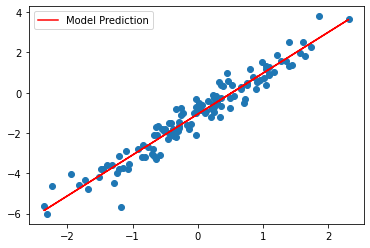

In [51]:
import matplotlib.pyplot as plt
plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend()
plt.show()

## Advanced Autodiff

### Stopping gradients

jax.lax.stop_gradient is the primitive used for this purpose.

Example 1: TD(0) update (RL algorithm).

The TD(0) update to the network parameters is:

$$
\Delta \theta = (r_t + v_{\theta}(s_t) - v_{\theta}(s_{t-1})) \nabla v_{\theta}(s_{t-1})
$$

This update is not the gradient of any loss function.

However, it can be **written** as the gradient of the pseudo loss function

$$
L(\theta) = [r_t + v_{\theta}(s_t) - v_{\theta}(s_{t-1})]^2
$$

if the dependency of the target $r_t + v_{\theta}(s_t)$ on the parameter $\theta$ is ignored.

In [ ]:
# Value function and initial parameters
value_fn = lambda theta, state: jnp.dot(theta, state)
theta = jnp.array([0.1, -0.1, 0.])

# An example transition
s_tm1 = jnp.array([1., 2., -1.])
r_t = jnp.array(1.)
s_t = jnp.array([2., 1., 0.])

def td_loss(theta, s_tm1, r_t, s_t):
    v_tm1 = value_fn(theta, s_tm1)
    target = r_t + value_fn(theta, s_t)
    return (jax.lax.stop_gradient(target) - v_tm1) ** 2

td_update = jax.grad(td_loss)
delta_theta = td_update(theta, s_tm1, r_t, s_t)

delta_theta

In [ ]:
# Example 2: straight-through estimator 
# (used in e.g. VQ-VAE, check out my video: https://www.youtube.com/watch?v=VZFVUrYcig0)

def f(x):
    return jnp.round(x)  # non-differentiable

def straight_through_f(x):
    return x + jax.lax.stop_gradient(f(x) - x)

print("f(x): ", f(3.2))
print("straight_through_f(x):", straight_through_f(3.2))

print("grad(f)(x):", jax.grad(f)(3.2))
print("grad(straight_through_f)(x):", jax.grad(straight_through_f)(3.2))

"In many frameworks (PyTorch, TF, Theano) it is often not trivial to compute
per-example gradients, because the library directly accumulates the gradient
over the batch. Naive workarounds, such as computing a separate loss per example
and then aggregating the resulting gradients are typically very inefficient."

In [83]:
perex_grads = jax.jit(jax.vmap(jax.grad(td_loss), in_axes=(None, 0, 0, 0)))

batched_s_tm1 = jnp.stack([s_tm1, s_tm1])
batched_r_t = jnp.stack([r_t, r_t])
batched_s_t = jnp.stack([s_t, s_t])

perex_grads(theta, batched_s_tm1, batched_r_t, batched_s_t)

# Task time it

DeviceArray([[-2.4, -4.8,  2.4],
             [-2.4, -4.8,  2.4]], dtype=float32)

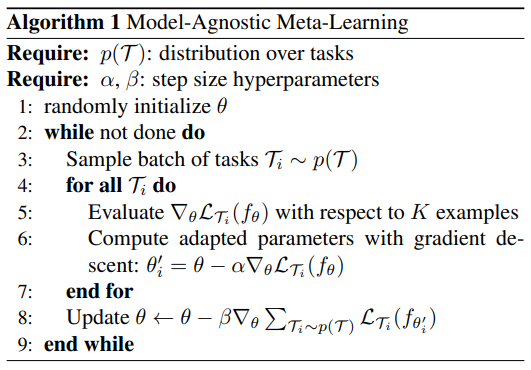

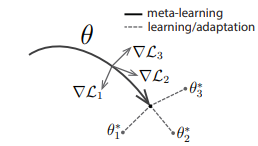

In [ ]:
# Very easy to do in JAX
def meta_loss_fn(params, data):
    """Computes the loss after one step of SGD."""
    grads = jax.grad(loss_fn)(params, data)
    return loss_fn(params - lr * grads, data)

meta_grads = jax.grad(meta_loss_fn)(params, data)

# Custom derivative rules, etc. take a look at advanced tutorials in the docs.
# e.g. https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html